# Corona Virus World Data Analysis (COVID - 2019)

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 
from numpy import exp
import os

from scipy import optimize

from scipy import integrate
from scipy.optimize import leastsq, curve_fit

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,India,Germany,China
0,2020-01-22,0,1,0,0,548
1,2020-01-23,0,1,0,0,643
2,2020-01-24,0,2,0,0,920
3,2020-01-25,0,2,0,0,1406
4,2020-01-26,0,5,0,0,2075


In [3]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

# Simulative approach to calculate SIR curves

In [5]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

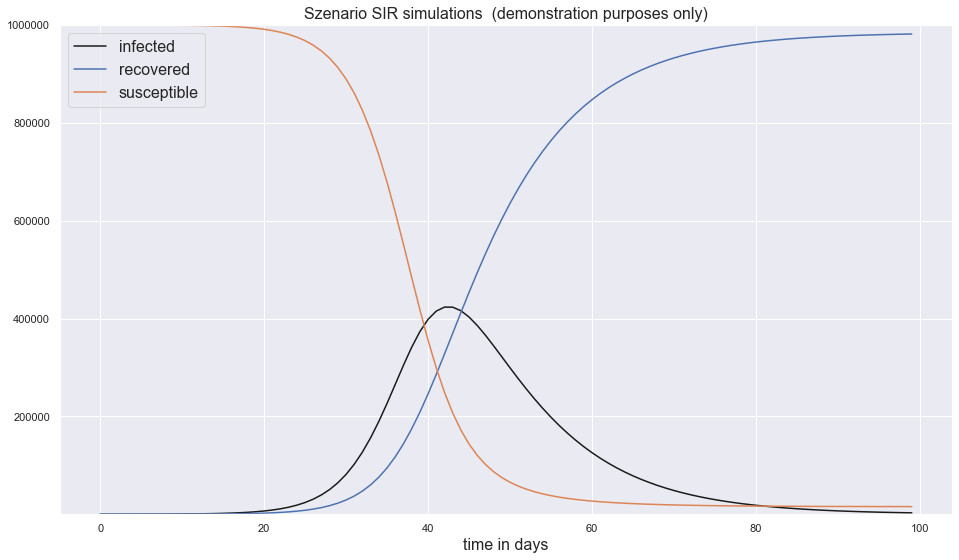

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [7]:
ydata = np.array(df_analyse.Germany[10:])
t=np.arange(len(ydata))

In [8]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [9]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [10]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [11]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([8.00000000e+00, 1.07988282e+01, 1.45768116e+01, 1.96764798e+01,
       2.65601729e+01, 3.58519294e+01, 4.83940152e+01, 6.53231911e+01,
       8.81735968e+01, 1.19015507e+02, 1.60642410e+02, 2.16823140e+02,
       2.92641471e+02, 3.94953198e+02, 5.33000678e+02, 7.19237962e+02,
       9.70436535e+02, 1.30916332e+03, 1.76574925e+03, 2.38089870e+03,
       3.20912531e+03, 4.32323431e+03, 5.82009455e+03, 7.82793430e+03,
       1.05153152e+04, 1.41017209e+04, 1.88692327e+04, 2.51738924e+04,
       3.34538790e+04, 4.42293718e+04, 5.80860088e+04, 7.56308574e+04,
       9.74087340e+04, 1.23771164e+05, 1.54704840e+05, 1.89653059e+05,
       2.27394875e+05, 2.66061512e+05, 3.03341427e+05, 3.36849318e+05,
       3.64548090e+05, 3.85077915e+05, 3.97892527e+05, 4.03195497e+05,
       4.01744947e+05, 3.94617479e+05, 3.83000092e+05, 3.68041759e+05,
       3.50766866e+05, 3.32037558e+05, 3.12548457e+05, 2.92839581e+05,
       2.73317448e+05, 2.54278247e+05, 2.35929749e+05, 2.18410491e+05,
      

In [12]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\satya\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\satya\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
C:\Users\satya\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
C:\Users\satya\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
C:\Users\satya\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00175725 0.00164396]  start infect: 8
Optimal parameters: beta = 0.11004080041614092  and gamma =  0.037224863113538564


In [13]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

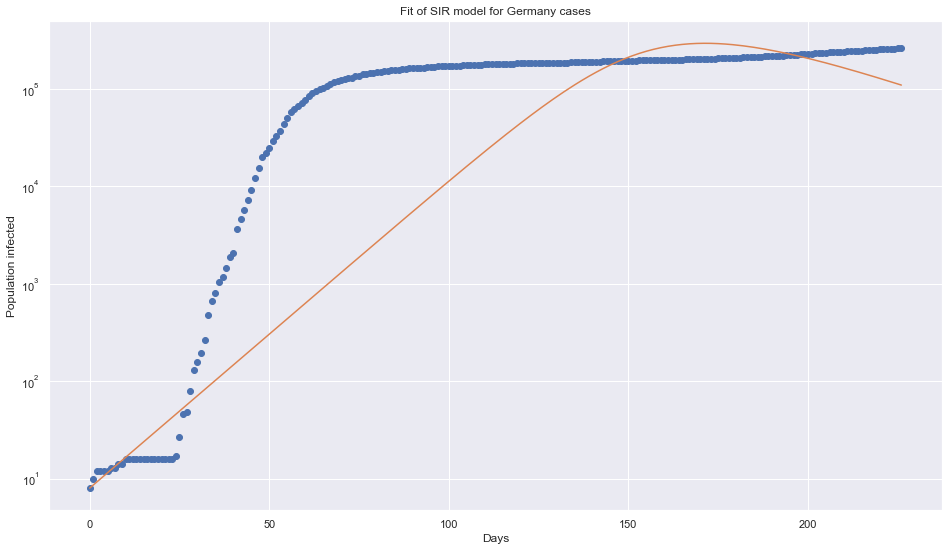

Optimal parameters: beta = 0.11004080041614092  and gamma =  0.037224863113538564
Basic Reproduction Number R0  2.9561102771690093
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [14]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in SIR (infection rate)

In [15]:
t_initial=10
t_intro_measures=14
t_hold=150
t_relax=21

beta_max=0.4
beta_min=0.13075
gamma=0.1213
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

In [16]:
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.37928846, 0.35857692, 0.33786538, 0.31715385,
       0.29644231, 0.27573077, 0.25501923, 0.23430769, 0.21359615,
       0.19288462, 0.17217308, 0.15146154, 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075   ,
       0.13075   , 0.13075   , 0.13075   , 0.13075   , 0.13075

In [17]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

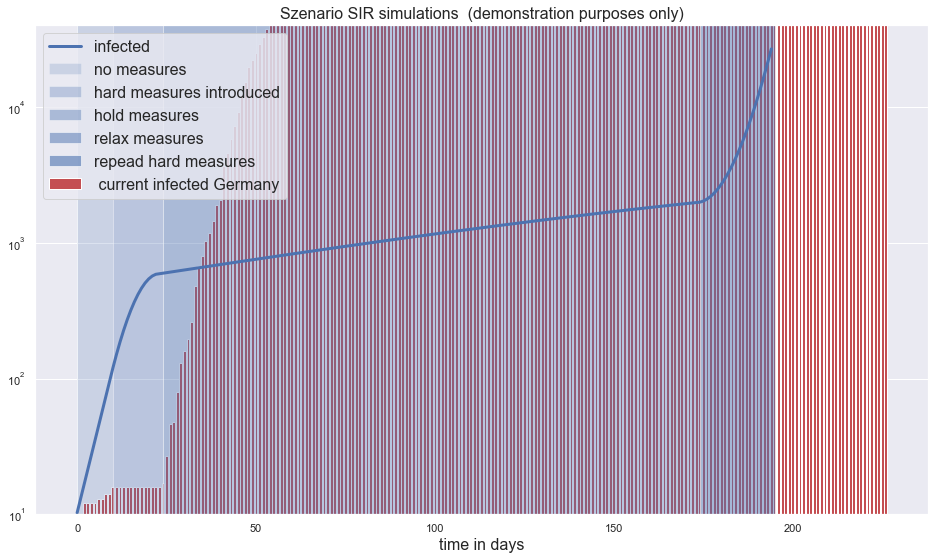

In [18]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});